# InnerPiSSA  Analyse sweeps and ablations
## Analysis Principles

**Main metric**: `ipissa_vh_range` = T_test / nll_degradation
- T_test = slope of logprob vs coefficient (steering effect)
- nll_degradation = coherence loss (model quality preservation)
- This is the primary metric for comparing methods

**Auxiliary metrics**:
- `symmetry`: min(|neg-zero|, |pos-zero|) / max(...) - how symmetric is bidirectional steering
- `loss_gap`: val_loss - train_loss - overfitting indicator

**Comparison principles**:
1. **Best vs mean baseline**: Use mean of baseline runs (not best) - best is sensitive to n_runs
2. **Within-sweep comparisons**: Control for model/hyperparams when analyzing sweep variables
3. **Exclude intentionally-broken runs**: lr=1.0, lr=1e-6 are ablation failures, not fair comparisons
4. **Resistance by metric sign**: "honest" vs "dishonest" direction, not arbitrary coefficient sign

**Color conventions**:
- Red = toward honest (positive ipissa_range)
- Blue = toward dishonest (negative ipissa_range)
- Green = low gap (good coherence)

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from loguru import logger
from ipissa.config import proj_root
import re
from tqdm.auto import tqdm

sns.set_style("whitegrid")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)

## Load Data

In [57]:
df_full = pd.read_csv('../outputs/wandb_results.csv')
df_summary = pd.read_csv('../outputs/wandb_summary.csv')

# Compute loss_gap (overfitting metric: val - train)
df_full['loss_gap'] = df_full['val_loss_total'] - df_full['train_loss_total']

# Load baseline results for comparison
df_prompting = pd.read_csv('../outputs/prompting_results.csv')
df_repeng = pd.read_csv('../outputs/repeng_results.csv')

# Create lookup dicts for baseline scores by model
prompting_baseline = df_prompting.groupby('model_name')['main_score'].mean().to_dict()
repeng_baseline = df_repeng.groupby('model_name')['main_score'].mean().to_dict()

# Add baseline scores to df_full based on model_name
df_full['prompting_score'] = df_full['model_name'].map(prompting_baseline)
df_full['repeng_score'] = df_full['model_name'].map(repeng_baseline)

# Compute gain % vs prompting: (innerpissa - prompting) / prompting * 100
df_full['gain_vs_prompting'] = (df_full['main_metric'] - df_full['prompting_score']) / df_full['prompting_score'].abs() * 100
df_full['gain_vs_repeng'] = (df_full['main_metric'] - df_full['repeng_score']) / df_full['repeng_score'].abs() * 100

print(f"Total runs: {len(df_full)}")
print(f"Runs with prompting baseline: {df_full['prompting_score'].notna().sum()}")

print(f"\nBaseline scores by model:")
for model in df_full['model_name'].dropna().unique()[:5]:
    p = prompting_baseline.get(model, np.nan)
    r = repeng_baseline.get(model, np.nan)
    print(f"  {model[:40]}: prompting={p:.1f}, repeng={r:.1f}")

df_full.head(3)

Total runs: 177
Runs with prompting baseline: 176

Baseline scores by model:
  unsloth/Llama-3.1-8B-Instruct: prompting=293.9, repeng=996.0
  google/gemma-3-270m-it: prompting=nan, repeng=nan
  Qwen/Qwen3-4B-Instruct-2507: prompting=613.2, repeng=284.1
  Qwen/Qwen3-4B-Base: prompting=15.4, repeng=1057.0
  Qwen/Qwen3-14B: prompting=113.7, repeng=1.8


,run_id,name,state,created_at,url,log_file,args,git_commit,gpu,layer_num,main_metric,runtime,baseline_effect_InnerPiSSA,baseline_effect_s_steer,baseline_effect_pca,baseline_effect_prompting,baseline_effect_repeng,val_loss_total,val_loss_proj,val_loss_coh,val_loss_monotonic,val_proj_diff,val_logp_degradation,train_loss_total,train_loss_proj,train_loss_coh,train_loss_monotonic,train_proj_diff,train_logp_degradation,r,bs,lr,wd,coh,mono,quick,rot_u,rot_v,PROMPT,n_logs,modules,scale_s,verbose,PERSONAS,coh_temp,n_depths,n_epochs,depth_end,loss_type,use_wandb,val_split,coh_thresh,coh_weight,model_name,output_dir,wandb_tags,depth_start,loss_depths,max_samples,mono_margin,mono_weight,adapter_type,coh_adaptive,dataset_name,effective_bs,n_last_tokens,wandb_project,eval_max_tokens,experiment_name,save_checkpoints,eval_max_dilemmas,quantization_type,early_stop_patience,data_aware_init,seed,loss_use_V,loss_modules,max_rotation_angle,loss_gap,prompting_score,repeng_score,gain_vs_prompting,gain_vs_repeng
0,2rraqz7z,l8b-raw-r64,finished,2025-11-24T14:18:22Z,https://wandb.ai/wassname/InnerPiSSA/runs/2rra...,/workspace/InnerPiSSA_private/outputs/wandb_ca...,l8b-80gb,927a0a94e31c5e314cdafc8b3f7dd44c7f17a10b,NVIDIA A100-SXM4-80GB,27.0,84.874883,4212,-1.495592,NaN,NaN,-0.285553,-1.502312,-2.917353,-2.164207,0.127638,1.155784,-2.164207,NaN,-2.280865,-1.165114,0.0,0.049362,-1.165114,NaN,64,6,0.002,0.01,True,True,False,False,True,You are a model organism for alignment researc...,20,"['o_proj', 'down_proj']",add2,False,"[['honest', 'a truthful'], ['dishonest', 'an u...",4.0,14,10,-3.0,raw,True,0.15,0.5,40.0,unsloth/Llama-3.1-8B-Instruct,/workspace/InnerPiSSA_private/outputs/adapters,NaN,0.3,[0.85],800,0.05,100,innerpissa,False,honest,64,6,InnerPiSSA,288,NaN,False,NaN,none,4,False,NaN,True,['up_proj'],NaN,-0.636488,293.890793,996.001392,-71.120265,-91.478437
1,9sup7k1t,l8b-raw-r64,finished,2025-11-24T14:18:22Z,https://wandb.ai/wassname/InnerPiSSA/runs/9sup...,/workspace/InnerPiSSA_private/outputs/wandb_ca...,l8b-80gb,927a0a94e31c5e314cdafc8b3f7dd44c7f17a10b,NVIDIA A100-SXM4-80GB,27.0,228.129886,4205,-1.495592,NaN,NaN,-0.285553,-1.502312,-2.786765,-2.575055,0.151881,2.059582,-2.575055,NaN,-2.871846,-1.435923,0.0,0.000000,-1.435923,NaN,64,6,0.002,0.01,True,True,False,False,True,You are a model organism for alignment researc...,20,"['o_proj', 'down_proj']",add2,False,"[['honest', 'a truthful'], ['dishonest', 'an u...",4.0,14,10,-3.0,raw,True,0.15,0.5,40.0,unsloth/Llama-3.1-8B-Instruct,/workspace/InnerPiSSA_private/outputs/adapters,NaN,0.3,[0.85],800,0.05,100,innerpissa,False,honest,64,6,InnerPiSSA,288,NaN,False,NaN,none,4,False,NaN,True,['up_proj'],NaN,0.085081,293.890793,996.001392,-22.375967,-77.095425
2,g3jd1nce,l8b-raw-r128,finished,2025-11-24T02:57:47Z,https://wandb.ai/wassname/InnerPiSSA/runs/g3jd...,/workspace/InnerPiSSA_private/outputs/wandb_ca...,l8b-80gb,4bb18b44a24ebd69805af2cf88d8fbef5c96393b,NVIDIA H100 NVL,27.0,776.761634,1091,-1.501976,NaN,NaN,NaN,NaN,-8.558153,-4.663261,0.405377,0.000000,-4.663261,NaN,-9.641036,-4.820518,0.0,0.000000,-4.820518,NaN,128,6,0.008,1.00,True,True,False,False,True,Pretend you're {persona} person making stateme...,20,"['o_proj', 'down_proj']",add2,False,"[['a truthful'], ['an untruthful']]",4.0,12,20,-3.0,raw,True,0.15,0.5,30.0,unsloth/Llama-3.1-8B-Instruct,/workspace/InnerPiSSA_private/outputs/adapters,NaN,0.3,[0.85],800,0.10,200,innerpissa,True,honest,64,6,InnerPiSSA,288,NaN,False,NaN,none,4,False,NaN,True,['up_proj'],NaN,1.082883,293.890793,996.001392,164.302813,-22.011993


## Step 1: Recalculate Symmetry from Logs

Parse each run's output.log to get:
- Baseline-relative symmetry: `min(|neg-zero|, |pos-zero|) / max(...)`
- Resistant direction: which side (neg or pos) moved LESS from baseline
- Raw scores for both InnerPiSSA and prompting

In [58]:
# Step 1: Parse logs to extract Value/Honesty at coeff=-1,0,+1
from ipissa.config import proj_root
import re
import json
from pathlib import Path

cache_dir = proj_root / "outputs" / "wandb_cache"

def parse_value_honesty_from_log(log_file: Path) -> dict:
    """Extract Value/Honesty scores at coeff=-1, 0, +1 from InnerPiSSA results table.
    
    Returns: {vh_neg, vh_zero, vh_pos, symmetry, resistant_toward}
    """
    if not log_file.exists():
        print(f"Log file does not exist: {log_file}")
        return {}
    
    try:
        logs = log_file.read_text()
    except Exception as e:
        print(f"Error reading {log_file}: {e}")
        return {}
    
    # Find InnerPiSSA results table
    pattern = r'Results for method: InnerPiSSA.*?(?=Results for method:|$)'
    match = re.search(pattern, logs, re.DOTALL)
    if not match:
        return {}
    
    table_text = match.group(0)
    
    # Parse Value/Honesty row: "Value/Honesty   -3.0767  -3.1215  -3.1828"
    vh_pattern = r'Value/Honesty\s+([-\d.]+)\s+([-\d.]+)\s+([-\d.]+)'
    vh_match = re.search(vh_pattern, table_text)
    if not vh_match:
        return {}
    
    neg, zero, pos = float(vh_match.group(1)), float(vh_match.group(2)), float(vh_match.group(3))
    
    # Compute symmetry: min(|neg-zero|, |pos-zero|) / max(...)
    dist_neg = abs(neg - zero)
    dist_pos = abs(pos - zero)
    
    metrics = {
        'vh_neg': neg,
        'vh_zero': zero, 
        'vh_pos': pos,
    }
    
    if max(dist_neg, dist_pos) > 0.01:
        metrics['symmetry'] = min(dist_neg, dist_pos) / max(dist_neg, dist_pos)
        # Resistant direction: which way has smaller effect?
        metrics['resistant_toward'] = 'honest' if dist_pos < dist_neg else 'dishonest'
    
    return metrics

# Process all runs
print("Parsing logs for Value/Honesty...")
run_metrics = []

for _, row in tqdm(df_full.iterrows(), total=len(df_full)):
    run_id = row['run_id']
    log_file = cache_dir / run_id / "output.log"
    
    m = parse_value_honesty_from_log(log_file)
    m['run_id'] = run_id
    run_metrics.append(m)

df_metrics = pd.DataFrame(run_metrics)
print(f"Parsed {df_metrics['symmetry'].notna().sum()} runs with valid Value/Honesty")

# Merge with original data
df = df_full.merge(df_metrics, on='run_id', how='left')

# Summary
valid = df[df['symmetry'].notna()]
print(f"\n=== Value/Honesty Summary ===")
print(f"vh_neg:  {valid['vh_neg'].mean():.2f} ± {valid['vh_neg'].std():.2f}")
print(f"vh_zero: {valid['vh_zero'].mean():.2f} ± {valid['vh_zero'].std():.2f}")  
print(f"vh_pos:  {valid['vh_pos'].mean():.2f} ± {valid['vh_pos'].std():.2f}")
print(f"symmetry: {valid['symmetry'].mean():.2f} ± {valid['symmetry'].std():.2f}")

print(f"\n=== Resistant Direction ===")
print(df['resistant_toward'].value_counts())

Parsing logs for Value/Honesty...


  0%|          | 0/177 [00:00<?, ?it/s]

Parsed 176 runs with valid Value/Honesty

=== Value/Honesty Summary ===
vh_neg:  -0.59 ± 2.72
vh_zero: 0.07 ± 0.83
vh_pos:  1.25 ± 2.94
symmetry: 0.51 ± 0.29

=== Resistant Direction ===
resistant_toward
dishonest    100
honest        76
Name: count, dtype: int64


## Step 2: Combine Sweeps by Type

Load all sweep CSVs, combine by base name (ignoring date stamps).
For controlled comparisons, we'll look at within-sweep relative differences rather than absolute values across sweeps.

In [59]:
# Step 2: Load and combine sweeps by type
sweep_dir = Path('../outputs/sweep_groups')

# Option: only load the N most recent sweeps per type (None = load all)
N_LATEST_SWEEPS = 2  # e.g. set to 2 to only load 2 most recent sweeps per type

def get_sweep_base(name: str) -> str:
    """Remove timestamp: 'sweep-lr-20251123-1629' -> 'sweep-lr'"""
    return re.sub(r'-\d{8}-\d{4}', '', name.replace('.csv', ''))

def get_sweep_timestamp(name: str) -> str:
    """Extract timestamp: 'sweep-lr-20251123-1629' -> '20251123-1629'"""
    match = re.search(r'(\d{8}-\d{4})', name)
    return match.group(1) if match else '00000000-0000'

# Load all sweep CSVs
sweep_files = [f for f in sweep_dir.glob('*.csv') if '_summary' not in f.name]

# Group by base name
sweep_by_base = {}
for f in sweep_files:
    base = get_sweep_base(f.name)
    if base not in sweep_by_base:
        sweep_by_base[base] = []
    sweep_by_base[base].append(f)

# Sort each group by timestamp (descending) and optionally take only latest N
for base in sweep_by_base:
    sweep_by_base[base] = sorted(sweep_by_base[base], key=lambda f: get_sweep_timestamp(f.name), reverse=True)
    if N_LATEST_SWEEPS is not None:
        sweep_by_base[base] = sweep_by_base[base][:N_LATEST_SWEEPS]

# Load selected files
sweeps = {}
for base, files in sweep_by_base.items():
    dfs = []
    for f in files:
        df_sweep = pd.read_csv(f)
        df_sweep['sweep_file'] = f.name
        df_sweep['sweep_base'] = base
        dfs.append(df_sweep)
    
    combined = pd.concat(dfs, ignore_index=True)
    
    # Merge with parsed log metrics (symmetry, resistant_toward) 
    merge_cols = ['run_id', 'symmetry', 'resistant_toward']
    available_cols = [c for c in merge_cols if c in df_metrics.columns]
    combined = combined.merge(df_metrics[available_cols], on='run_id', how='left')
    
    # Add prompting/repeng baseline via model_name (run_id merge has 0 overlap with sweep CSVs)
    if 'model_name' in combined.columns:
        combined['prompting_score'] = combined['model_name'].map(prompting_baseline)
        combined['repeng_score'] = combined['model_name'].map(repeng_baseline)
        combined['gain_vs_prompting'] = (combined['main_metric'] - combined['prompting_score']) / combined['prompting_score'].abs() * 100
        combined['gain_vs_repeng'] = (combined['main_metric'] - combined['repeng_score']) / combined['repeng_score'].abs() * 100
    
    sweeps[base] = combined

print(f"Loaded {len(sweeps)} sweep types" + (f" (latest {N_LATEST_SWEEPS} each)" if N_LATEST_SWEEPS else "") + "\n")

# Define control variable and baseline value for each sweep
SWEEP_CONFIG = {
    'sweep-lr': {'var': 'lr', 'baseline': 0.004},
    'sweep-rank': {'var': 'r', 'baseline': 64},
    'sweep-rotation-angle': {'var': 'max_rotation_angle', 'baseline': float('inf')},
    'run-models': {'var': 'model_name', 'baseline': None},
    'ablate-constraints': {'var': 'args', 'baseline': 'q4b-80gb'},
    'ablate-modules': {'var': 'scale_s', 'baseline': 'add2'},
    'ablate-wd': {'var': 'wd', 'baseline': 0.0},
    'data-efficiency': {'var': 'max_examples', 'baseline': None},
    'sweep-layers': {'var': 'n_depths', 'baseline': None},
}

def summarize_sweep_mean(df_s, var, baseline_val):
    """Summarize sweep using groupby. main_metric is the t-stat steering effect."""
    if var not in df_s.columns:
        for alt in [var.replace('_', ''), var + 's']:
            if alt in df_s.columns:
                var = alt
                break
        else:
            return None, var
    
    # Define columns to aggregate
    agg_cols = {
        'main_metric': 'mean',
        'prompting_score': 'mean', 
        'gain_vs_prompting': 'mean',
        'loss_gap': 'mean',
        'symmetry': 'mean',
    }
    agg_cols = {k: v for k, v in agg_cols.items() if k in df_s.columns}
    
    df_result = (
        df_s.groupby(var, dropna=False)
        .agg(**{k: (k, v) for k, v in agg_cols.items()}, n=(var, 'size'))
        .reset_index()
    )
    df_result['is_baseline'] = df_result[var].apply(lambda x: '⭐' if baseline_val is not None and x == baseline_val else '')
    
    # Sort: baseline first, then by main metric descending
    if 'main_metric' in df_result.columns:
        df_result = df_result.sort_values(['is_baseline', 'main_metric'], ascending=[False, False])
    
    return df_result, var

def style_sweep_table(df, var_col):
    """Style a sweep summary table with color gradients and formatting."""
    styled = df.style
    
    # Format numeric columns
    format_dict = {
        'main_metric': '{:.1f}',
        'prompting_score': '{:.1f}',
        'gain_vs_prompting': '{:+.0f}',
        'loss_gap': '{:.2f}',
        'symmetry': '{:.2f}',
        'n': '{:.0f}',
    }
    format_dict = {k: v for k, v in format_dict.items() if k in df.columns}
    styled = styled.format(format_dict, na_rep='-')
    
    # Color gradients (higher is better for most)
    if 'main_metric' in df.columns:
        styled = styled.background_gradient(subset=['main_metric'], cmap='Greens')
    if 'gain_vs_prompting' in df.columns:
        styled = styled.background_gradient(subset=['gain_vs_prompting'], cmap='RdYlGn', vmin=-100, vmax=100)
    if 'symmetry' in df.columns:
        styled = styled.background_gradient(subset=['symmetry'], cmap='Blues')
    if 'loss_gap' in df.columns:
        styled = styled.background_gradient(subset=['loss_gap'], cmap='Reds_r')
    
    return styled

# Show each sweep
for sweep_name, config in SWEEP_CONFIG.items():
    if sweep_name not in sweeps:
        continue
    
    df_s = sweeps[sweep_name]
    control_var = config['var']
    
    summary_df, actual_var = summarize_sweep_mean(df_s, control_var, config['baseline'])
    
    if summary_df is not None:
        print(f"\n{'='*70}")
        print(f"Sweep: {sweep_name} (control: {actual_var})")
        print(f"{'='*70}")
        print(f"Runs: {len(df_s)}")
        print(summary_df.to_string(index=False))
    else:
        print(f"\n{sweep_name}: Could not find '{control_var}' column")

Loaded 10 sweep types (latest 2 each)


Sweep: sweep-lr (control: lr)
Runs: 12
     lr  main_metric  prompting_score  gain_vs_prompting  loss_gap  symmetry  n is_baseline
0.01000    462.83500       613.221816         -24.524049   1.86340  0.688075  2            
0.00100    178.05000       613.221816         -70.964829   2.15000  0.916658  2            
0.10000    135.85000       613.221816         -77.846515   3.71200  0.303336  2            
0.00001     39.28500       613.221816         -93.593672  -2.24250  0.806925  2            
0.00010     37.61500       613.221816         -93.866004   1.15155  0.350303  2            
1.00000     29.41115       613.221816         -95.203832   8.84300  0.464153  2            

Sweep: sweep-rank (control: r)
Runs: 10
  r  main_metric  prompting_score  gain_vs_prompting  loss_gap  symmetry  n is_baseline
 64     133.4000       613.221816         -78.246045   2.21520  0.211320  2           ⭐
256     196.0000       613.221816         -68.037667   1.435

In [63]:
# Display styled sweep tables (using mean per condition)
from IPython.display import display, HTML

for sweep_name in ['run-models', 'sweep-lr', 'sweep-rank', 'ablate-modules', 'ablate-wd', 
                   'sweep-rotation-angle', 'sweep-layers', 'data-efficiency', 'ablate-constraints']:
    if sweep_name not in sweeps:
        continue
    
    df_s = sweeps[sweep_name]
    config = SWEEP_CONFIG.get(sweep_name, {'var': 'unknown', 'baseline': None})
    v = config['var']
    
    summary_df, actual_var = summarize_sweep_mean(df_s, v, config['baseline'])
    
    if summary_df is None or len(summary_df) == 0:
        print(f"\n{sweep_name}: (No data or '{v}' not found)")
        continue
    
    # Sort by actual_var if it exists in the result
    if actual_var in summary_df.columns:
        summary_df = summary_df.sort_values(actual_var)
    
    n_dates = df_s['sweep_file'].nunique()
    
    # Truncate model names for display
    if actual_var == 'model_name':
        summary_df[actual_var] = summary_df[actual_var].apply(
            lambda x: str(x).split('/')[-1][:30] if pd.notna(x) else x
        )
    
    print(f"\n{sweep_name} (n={len(df_s)}, {n_dates} dates, control: {actual_var})")
    display(style_sweep_table(summary_df, actual_var))


run-models (n=17, 2 dates, control: model_name)


/media/wassname/SGIronWolf/projects5/2025/llm_moral_lb_v2/repeng/.venv/lib/python3.10/site-packages/pandas/io/formats/style.py:3807: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/media/wassname/SGIronWolf/projects5/2025/llm_moral_lb_v2/repeng/.venv/lib/python3.10/site-packages/pandas/io/formats/style.py:3808: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,model_name,main_metric,prompting_score,gain_vs_prompting,loss_gap,symmetry,n,is_baseline
0,Qwen3-0.6B,1473.0,179.8,+719,2.61,-,2,
1,Qwen3-14B,44.0,113.7,-61,5.79,-,1,
2,Qwen3-4B-Base,978.4,15.4,+6246,1.43,-,2,
3,Qwen3-4B-Instruct-2507,554.2,613.2,-10,0.12,-,2,
4,gemma-3-12b-it,22.2,470.1,-95,1.45,-,1,
5,gemma-3-1b-it,500.3,-,-,4.63,-,2,
6,gemma-3-270m-it,1002.7,-,-,0.73,-,2,
7,gemma-3-4b-it,85.6,277.2,-69,2.80,-,1,
8,Llama-3.1-8B-Instruct,344.5,293.9,+17,0.53,-,4,



sweep-lr (n=12, 2 dates, control: lr)


,lr,main_metric,prompting_score,gain_vs_prompting,loss_gap,symmetry,n,is_baseline
0,0.000010,39.3,613.2,-94,-2.24,0.81,2,
1,0.000100,37.6,613.2,-94,1.15,0.35,2,
2,0.001000,178.1,613.2,-71,2.15,0.92,2,
3,0.010000,462.8,613.2,-25,1.86,0.69,2,
4,0.100000,135.8,613.2,-78,3.71,0.30,2,
5,1.000000,29.4,613.2,-95,8.84,0.46,2,



sweep-rank (n=10, 2 dates, control: r)


,r,main_metric,prompting_score,gain_vs_prompting,loss_gap,symmetry,n,is_baseline
0,32,118.8,613.2,-81,1.11,0.34,2,
1,64,133.4,613.2,-78,2.22,0.21,2,⭐
2,128,18.5,613.2,-97,-0.23,0.41,2,
3,256,196.0,613.2,-68,1.44,0.32,2,
4,512,90.9,613.2,-85,9.53,0.04,2,



ablate-modules (n=12, 2 dates, control: scale_s)


/media/wassname/SGIronWolf/projects5/2025/llm_moral_lb_v2/repeng/.venv/lib/python3.10/site-packages/pandas/io/formats/style.py:3807: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/media/wassname/SGIronWolf/projects5/2025/llm_moral_lb_v2/repeng/.venv/lib/python3.10/site-packages/pandas/io/formats/style.py:3808: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,scale_s,main_metric,prompting_score,gain_vs_prompting,loss_gap,symmetry,n,is_baseline
0,add2,303.2,613.2,-51,2.01,-,12,⭐



ablate-wd (n=14, 2 dates, control: wd)


,wd,main_metric,prompting_score,gain_vs_prompting,loss_gap,symmetry,n,is_baseline
0,0.000000,323.1,613.2,-47,3.09,0.59,2,⭐
1,0.001000,431.5,613.2,-30,5.69,0.55,2,
2,0.010000,380.9,613.2,-38,6.28,0.21,2,
3,0.100000,165.7,613.2,-73,1.67,0.39,2,
4,1.000000,233.8,613.2,-62,0.77,0.04,2,
5,10.000000,216.0,613.2,-65,-0.38,0.59,2,
6,100.000000,31.8,613.2,-95,2.42,0.72,2,



sweep-rotation-angle (n=11, 1 dates, control: max_rotation_angle)


/media/wassname/SGIronWolf/projects5/2025/llm_moral_lb_v2/repeng/.venv/lib/python3.10/site-packages/pandas/io/formats/style.py:3807: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/media/wassname/SGIronWolf/projects5/2025/llm_moral_lb_v2/repeng/.venv/lib/python3.10/site-packages/pandas/io/formats/style.py:3808: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,max_rotation_angle,main_metric,prompting_score,gain_vs_prompting,loss_gap,symmetry,n,is_baseline
0,0.100000,453.7,613.2,-26,3.88,-,1,
1,0.200000,303.3,613.2,-51,0.54,-,1,
2,0.300000,236.6,613.2,-61,2.08,-,2,
3,0.500000,47.8,613.2,-92,0.39,-,1,
4,1.000000,356.3,613.2,-42,0.22,-,1,
5,inf,440.5,613.2,-28,1.43,-,5,⭐



sweep-layers (n=22, 2 dates, control: n_depths)


/media/wassname/SGIronWolf/projects5/2025/llm_moral_lb_v2/repeng/.venv/lib/python3.10/site-packages/pandas/io/formats/style.py:3807: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/media/wassname/SGIronWolf/projects5/2025/llm_moral_lb_v2/repeng/.venv/lib/python3.10/site-packages/pandas/io/formats/style.py:3808: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,n_depths,main_metric,prompting_score,gain_vs_prompting,loss_gap,symmetry,n,is_baseline
0,14,258.3,613.2,-58,2.21,-,22,



data-efficiency: (No data or 'max_examples' not found)

ablate-constraints (n=15, 2 dates, control: args)


,args,main_metric,prompting_score,gain_vs_prompting,loss_gap,symmetry,n,is_baseline
0,q4b-80gb,183.9,613.2,-70,5.30,-,1,⭐
1,q4b-80gb --data_aware_init,230.4,613.2,-62,3.73,0.97,2,
2,q4b-80gb --loss_use_V --loss_depths=0.8 --loss_modules up_proj,43.9,613.2,-93,0.86,0.74,1,
3,q4b-80gb --loss_use_V --loss_modules up_proj,10.1,613.2,-98,4.93,-,1,
4,q4b-80gb --mono --no_coh,819.1,613.2,+34,-0.48,-,1,
5,q4b-80gb --no_coh_adaptive,256.2,613.2,-58,2.74,0.35,2,
6,q4b-80gb --no_loss_use_V --loss_depths=0.5 --loss_modules o_proj down_proj,31.4,613.2,-95,0.70,0.70,2,
7,q4b-80gb --no_mono --coh,301.6,613.2,-51,0.34,-,1,
8,q4b-80gb --no_mono --no_coh,165.9,613.2,-73,-0.43,-,1,
9,q4b-80gb --no_rot_u --no_rot_v,14.7,613.2,-98,-1.28,-,1,


## Step 3: Answer Key Questions

Using controlled within-sweep comparisons where possible.

In [ ]:
# Step 3: Answer key questions with controlled comparisons

print("=" * 80)
print("KEY QUESTIONS")
print("=" * 80)

# Filter to good runs (generalize)
df_good = df[df['loss_gap'] < 3].copy()
print(f"\nUsing {len(df_good)} runs with good generalization (gap < 3)")

# Q1: What is the actual symmetry?
print("\n" + "-" * 80)
print("Q1: WHAT IS THE ACTUAL SYMMETRY?")
print("-" * 80)
print(f"Symmetry (Value/Honesty, baseline-relative):")
print(f"  All runs: {df['symmetry'].mean():.3f} ± {df['symmetry'].std():.3f}")
print(f"  Good runs (gap<3): {df_good['symmetry'].mean():.3f} ± {df_good['symmetry'].std():.3f}")
print(f"\n  Interpretation: symmetry ~0.5 means one direction gets ~2x the effect")

# Q2: Which direction is resistant?
print("\n" + "-" * 80)
print("Q2: WHICH DIRECTION IS RESISTANT?")
print("-" * 80)
print("'honest' = resists becoming more honest (smaller effect toward +metric)")
print("'dishonest' = resists becoming more dishonest (smaller effect toward -metric)")

print(f"\nValue/Honesty resistance (gap<3 runs):")
print(df_good['resistant_toward'].value_counts().to_string())

# By model
print("\nResistance by model:")
for model in df_good['model_name'].dropna().unique():
    subset = df_good[df_good['model_name'] == model]
    if len(subset) >= 3:
        honest_resist = (subset['resistant_toward'] == 'honest').mean()
        dishonest_resist = (subset['resistant_toward'] == 'dishonest').mean()
        short_name = model.split('/')[-1][:25]
        dominant = 'honest' if honest_resist > dishonest_resist else 'dishonest'
        print(f"  {short_name}: resists '{dominant}' in {100*max(honest_resist, dishonest_resist):.0f}% of runs")

# Q3: Steering effect size
print("\n" + "-" * 80)
print("Q3: STEERING EFFECT SIZE (Value/Honesty)")
print("-" * 80)

# Compute vh_range if not present
if 'vh_range' not in df_good.columns:
    df_good['vh_range'] = df_good['vh_pos'] - df_good['vh_neg']

df_compare = df_good[df_good['vh_range'].notna()].copy()
print(f"Runs with Value/Honesty data: {len(df_compare)}")

print(f"\nSteering range (vh_pos - vh_neg):")
print(f"  Mean: {df_compare['vh_range'].mean():.2f} ± {df_compare['vh_range'].std():.2f}")
print(f"  Median: {df_compare['vh_range'].median():.2f}")

print(f"\nEffect in each direction (from baseline vh_zero):")
df_compare['effect_pos'] = df_compare['vh_pos'] - df_compare['vh_zero']
df_compare['effect_neg'] = df_compare['vh_neg'] - df_compare['vh_zero']
print(f"  Toward honest (pos-zero):    {df_compare['effect_pos'].mean():+.2f} ± {df_compare['effect_pos'].std():.2f}")
print(f"  Toward dishonest (neg-zero): {df_compare['effect_neg'].mean():+.2f} ± {df_compare['effect_neg'].std():.2f}")

print("\nBy model:")
for model in df_compare['model_name'].dropna().unique():
    subset = df_compare[df_compare['model_name'] == model]
    if len(subset) >= 2:
        short_name = model.split('/')[-1][:25]
        vh_range = subset['vh_range'].mean()
        sym = subset['symmetry'].mean()
        print(f"  {short_name}: range={vh_range:+.2f}, symmetry={sym:.2f} (n={len(subset)})")

# Q4: What hyperparams affect symmetry?
print("\n" + "-" * 80)
print("Q4: WHAT HYPERPARAMS AFFECT SYMMETRY?")
print("-" * 80)

for col in ['rot_u', 'scale_s', 'loss_use_V']:
    if col in df_good.columns and df_good[col].nunique() > 1:
        print(f"\n{col}:")
        for val in sorted(df_good[col].dropna().unique(), key=str):
            subset = df_good[df_good[col] == val]
            if len(subset) >= 3:
                sym = subset['symmetry'].mean()
                print(f"  {val}: symmetry={sym:.3f} (n={len(subset)})")

print("\n" + "=" * 80)

KEY QUESTIONS

Using 84 runs with good generalization (gap < 3)

--------------------------------------------------------------------------------
Q1: WHAT IS THE ACTUAL SYMMETRY?
--------------------------------------------------------------------------------
Symmetry (Value/Honesty, baseline-relative):
  All runs: 0.506 ± 0.286
  Good runs (gap<3): 0.529 ± 0.280

  Interpretation: symmetry ~0.5 means one direction gets ~2x the effect

--------------------------------------------------------------------------------
Q2: WHICH DIRECTION IS RESISTANT?
--------------------------------------------------------------------------------
'honest' = resists becoming more honest (smaller effect toward +metric)
'dishonest' = resists becoming more dishonest (smaller effect toward -metric)

Value/Honesty resistance (gap<3 runs):
resistant_toward
dishonest    45
honest       39

Resistance by model:
  Llama-3.1-8B-Instruct: resists 'dishonest' in 83% of runs
  Qwen3-4B-Instruct-2507: resists 'dishones

## Overall Symmetry Distribution

KeyError: 'symmetry_mean'

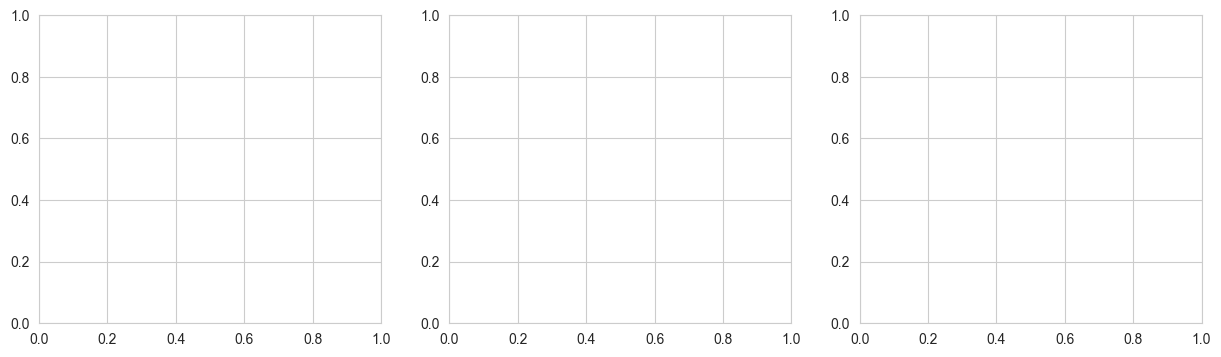

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(df_full['symmetry_mean'].dropna(), bins=30, edgecolor='black')
axes[0].axvline(1.0, color='red', linestyle='--', label='Perfect symmetry')
axes[0].set_xlabel('symmetry_mean (|neg|/|pos|)')
axes[0].set_title(f'Symmetry Distribution\nMean: {df_full["symmetry_mean"].mean():.3f}')
axes[0].legend()

axes[1].hist(df_full['dose_monotonic_frac'].dropna(), bins=20, edgecolor='black')
axes[1].set_xlabel('dose_monotonic_frac')
axes[1].set_title(f'Dose-Dependence Distribution\nMean: {df_full["dose_monotonic_frac"].mean():.3f}')

axes[2].hist(df_full['loss_gap'].dropna(), bins=30, edgecolor='black')
axes[2].axvline(3, color='red', linestyle='--', label='Gap=3 threshold')
axes[2].set_xlabel('loss_gap (val - train)')
axes[2].set_title(f'Generalization Gap\nMean: {df_full["loss_gap"].mean():.2f}')
axes[2].legend()

plt.tight_layout()
plt.show()

print(f"\nSymmetry stats:")
print(df_full['symmetry_mean'].describe())
print(f"\nRuns with good generalization (gap<3): {(df_full['loss_gap'] < 3).sum()} / {len(df_full)} ({100*(df_full['loss_gap'] < 3).mean():.0f}%)")

## Symmetry vs Generalization

Does symmetry correlate with better generalization?

In [ ]:
df_good = df_full[df_full['loss_gap'] < 3]
df_bad = df_full[df_full['loss_gap'] >= 3]

print("=== SYMMETRY BY GENERALIZATION QUALITY ===\n")
print(f"Good generalization (loss_gap < 3): {len(df_good)} runs")
print(f"  symmetry_mean: {df_good['symmetry_mean'].mean():.3f} ± {df_good['symmetry_mean'].std():.3f}")
print(f"  dose_monotonic: {df_good['dose_monotonic_frac'].mean():.3f} ± {df_good['dose_monotonic_frac'].std():.3f}")
print(f"  main_metric: {df_good['main_metric'].mean():.1f} ± {df_good['main_metric'].std():.1f}")

print(f"\nPoor generalization (loss_gap >= 3): {len(df_bad)} runs")
print(f"  symmetry_mean: {df_bad['symmetry_mean'].mean():.3f} ± {df_bad['symmetry_mean'].std():.3f}")
print(f"  dose_monotonic: {df_bad['dose_monotonic_frac'].mean():.3f} ± {df_bad['dose_monotonic_frac'].std():.3f}")
print(f"  main_metric: {df_bad['main_metric'].mean():.1f} ± {df_bad['main_metric'].std():.1f}")

print(f"\nCorrelations:")
print(f"  symmetry_mean vs loss_gap: {df_full[['symmetry_mean', 'loss_gap']].corr().iloc[0,1]:.3f}")
print(f"  dose_monotonic vs loss_gap: {df_full[['dose_monotonic_frac', 'loss_gap']].corr().iloc[0,1]:.3f}")
print(f"  symmetry_mean vs main_metric: {df_full[['symmetry_mean', 'main_metric']].corr().iloc[0,1]:.3f}")

## Rotation Configurations (rot_u, rot_v)

Do rotations achieve better symmetry?

=== ROTATION CONFIGURATIONS ===

             rot_config   n  symmetry_mean  symmetry_std  loss_gap_mean  pct_gap_lt3  metric_mean
rot_u=False, rot_v=True 171       0.505363      0.287798       5.072368    47.368421   302.357961
 rot_u=True, rot_v=True   4       0.556828      0.329944       2.129284    25.000000   363.407493


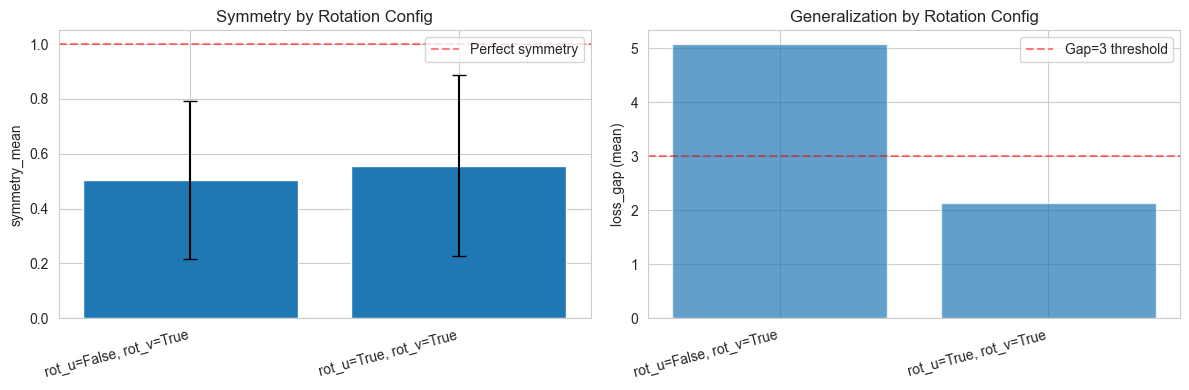

In [ ]:
print("=== ROTATION CONFIGURATIONS ===\n")

# Create rotation config label (df has the merged log metrics)
df['rot_config'] = df.apply(
    lambda r: f"rot_u={r['rot_u']}, rot_v={r['rot_v']}" if pd.notna(r.get('rot_u')) else None, axis=1
)

df_rot = (
    df[df['rot_config'].notna()]
    .groupby('rot_config')
    .agg(
        n=('rot_config', 'size'),
        symmetry_mean=('symmetry', 'mean'),
        symmetry_std=('symmetry', 'std'),
        loss_gap_mean=('loss_gap', 'mean'),
        pct_gap_lt3=('loss_gap', lambda x: 100 * (x < 3).mean()),
        metric_mean=('main_metric', 'mean'),
    )
    .reset_index()
    .query('n > 2')
)
print(df_rot.to_string(index=False))

if len(df_rot) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    x = range(len(df_rot))
    axes[0].bar(x, df_rot['symmetry_mean'], yerr=df_rot['symmetry_std'], capsize=5)
    axes[0].axhline(1.0, color='red', linestyle='--', alpha=0.5, label='Perfect symmetry')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(df_rot['rot_config'], rotation=15, ha='right')
    axes[0].set_ylabel('symmetry_mean')
    axes[0].set_title('Symmetry by Rotation Config')
    axes[0].legend()

    axes[1].bar(x, df_rot['loss_gap_mean'], alpha=0.7)
    axes[1].axhline(3, color='red', linestyle='--', alpha=0.5, label='Gap=3 threshold')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(df_rot['rot_config'], rotation=15, ha='right')
    axes[1].set_ylabel('loss_gap (mean)')
    axes[1].set_title('Generalization by Rotation Config')
    axes[1].legend()

    plt.tight_layout()
    plt.show()
else:
    print("Not enough data for rotation config analysis")

## Scale_s Configurations

Does multiplicative scaling (scale_s=mult) achieve symmetry?

=== SCALE_S CONFIGURATIONS ===

scale_s   n  symmetry_mean  symmetry_std  loss_gap_mean  pct_gap_lt3  metric_mean
   add2 174       0.508747      0.286664       4.796478    48.275862   302.706224
   none   3       0.348868      0.261998       7.006127     0.000000   165.397031


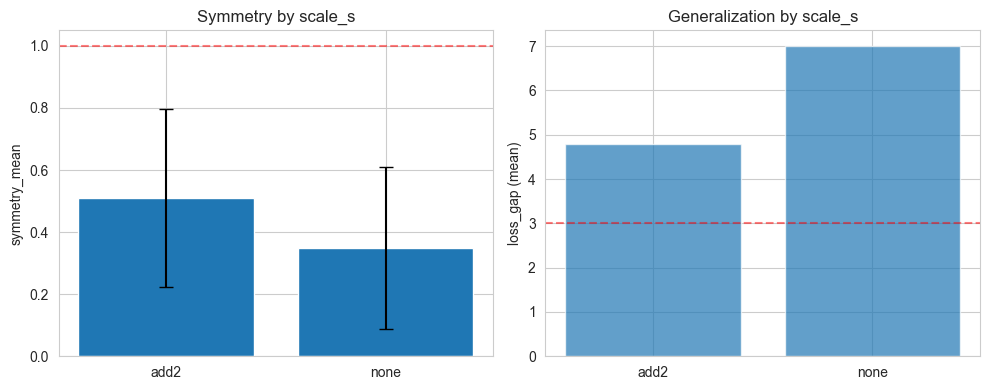

In [ ]:
print("=== SCALE_S CONFIGURATIONS ===\n")

df_scale = (
    df[df['scale_s'].notna()]
    .groupby('scale_s')
    .agg(
        n=('scale_s', 'size'),
        symmetry_mean=('symmetry', 'mean'),
        symmetry_std=('symmetry', 'std'),
        loss_gap_mean=('loss_gap', 'mean'),
        pct_gap_lt3=('loss_gap', lambda x: 100 * (x < 3).mean()),
        metric_mean=('main_metric', 'mean'),
    )
    .reset_index()
    .query('n > 2')
    .sort_values('n', ascending=False)
)
print(df_scale.to_string(index=False))

if len(df_scale) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    x = range(len(df_scale))
    axes[0].bar(x, df_scale['symmetry_mean'], yerr=df_scale['symmetry_std'], capsize=5)
    axes[0].axhline(1.0, color='red', linestyle='--', alpha=0.5)
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(df_scale['scale_s'], rotation=0)
    axes[0].set_ylabel('symmetry_mean')
    axes[0].set_title('Symmetry by scale_s')

    axes[1].bar(x, df_scale['loss_gap_mean'], alpha=0.7)
    axes[1].axhline(3, color='red', linestyle='--', alpha=0.5)
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(df_scale['scale_s'], rotation=0)
    axes[1].set_ylabel('loss_gap (mean)')
    axes[1].set_title('Generalization by scale_s')

    plt.tight_layout()
    plt.show()
else:
    print("Not enough data for scale_s analysis")

## Combined Analysis: rot_u + scale_s

Critical test: does rot_u + scale_s=mult achieve theoretical symmetry?

In [ ]:
print("=== ROT_U + SCALE_S COMBINATIONS ===\n")

df_combo = (
    df[(df['rot_u'].notna()) & (df['scale_s'].notna())]
    .groupby(['rot_u', 'scale_s'])
    .agg(
        n=('rot_u', 'size'),
        symmetry_mean=('symmetry', 'mean'),
        symmetry_std=('symmetry', 'std'),
        loss_gap_mean=('loss_gap', 'mean'),
        pct_gap_lt3=('loss_gap', lambda x: 100 * (x < 3).mean()),
        metric_mean=('main_metric', 'mean'),
    )
    .reset_index()
    .query('n > 1')
)
df_combo['config'] = df_combo.apply(lambda r: f"rot_u={r['rot_u']}, {r['scale_s']}", axis=1)
df_combo = df_combo.sort_values(['rot_u', 'scale_s'], ascending=[False, True])
print(df_combo[['config', 'n', 'symmetry_mean', 'loss_gap_mean', 'pct_gap_lt3', 'metric_mean']].to_string(index=False))

# Highlight theoretical configs
print("\n=== THEORETICAL SYMMETRY CONFIGS ===")
print("rot_u=True + scale_s=mult should achieve perfect symmetry (alpha reversal):")
mult_rot = df_combo[(df_combo['rot_u'] == True) & (df_combo['scale_s'] == 'mult')]
if len(mult_rot) > 0:
    r = mult_rot.iloc[0]
    print(f"  {r['n']:.0f} runs, symmetry={r['symmetry_mean']:.3f}, gap={r['loss_gap_mean']:.2f}")
else:
    print("  No runs found!")

print("\nrot_u=False + scale_s=add2 (baseline):")
baseline = df_combo[(df_combo['rot_u'] == False) & (df_combo['scale_s'] == 'add2')]
if len(baseline) > 0:
    r = baseline.iloc[0]
    print(f"  {r['n']:.0f} runs, symmetry={r['symmetry_mean']:.3f}, gap={r['loss_gap_mean']:.2f}")

## Sweep Group Analysis

Examine per-sweep patterns to control for confounds (model, hyperparams, etc.)

In [ ]:
# Properly aggregate sweeps: combine all runs of same sweep type across dates
import re
from pathlib import Path

sweep_dir = Path('../outputs/sweep_groups')

def get_sweep_base(name):
    """Remove timestamp: 'sweep-lr-20251123-1629' -> 'sweep-lr'"""
    return re.sub(r'-\d{8}-\d{4}', '', name.replace('.csv', ''))

# Load and combine all sweep CSVs by base name
sweep_files = list(sweep_dir.glob('*.csv'))
sweep_files = [f for f in sweep_files if '_summary' not in f.name]

sweep_data = {}
for f in sweep_files:
    base = get_sweep_base(f.name)
    df_sweep = pd.read_csv(f)
    if base not in sweep_data:
        sweep_data[base] = []
    sweep_data[base].append(df_sweep)

# Combine into single dataframes per sweep type
sweep_combined = {}
for base, dfs in sweep_data.items():
    sweep_combined[base] = pd.concat(dfs, ignore_index=True)
    
print(f"Found {len(sweep_combined)} sweep types:")
for name, df in sorted(sweep_combined.items(), key=lambda x: -len(x[1])):
    print(f"  {name}: {len(df)} runs across {len(sweep_data[name])} dates")

## Within-Sweep Controlled Comparisons

The right way to analyze sweeps: look at the **controlled variable within each sweep**, not means across different experiments.

In [ ]:
# For each sweep type, identify the controlled variable and show within-sweep comparison

def analyze_sweep_controlled(df, sweep_name):
    """Find the variable that varies within a sweep and compare outcomes using groupby."""
    # Identify columns that vary (categorical or few unique values)
    exclude = {'name', 'run_id', 'url', 'run_group', 'sweep_base', 'symmetry_mean', 'loss_gap', 'main_metric', 'dose_monotonic_frac'}
    varying_cols = [
        (c, df[c].nunique()) 
        for c in df.columns
        if (df[c].dtype in ['object', 'bool'] or df[c].nunique() <= 10)
        and df[c].nunique() > 1 
        and c not in exclude
    ]
    
    if not varying_cols:
        return None
        
    # Sort by number of unique values (prefer 2-5 values)
    varying_cols.sort(key=lambda x: abs(x[1] - 3))
    control_var = varying_cols[0][0]
    
    # Aggregate using groupby
    df_result = (
        df.groupby(control_var, dropna=False)
        .agg(
            n=(control_var, 'size'),
            symmetry=('symmetry_mean', 'mean'),
            gap=('loss_gap', 'mean'),
            metric=('main_metric', 'mean'),
            gap_lt3_pct=('loss_gap', lambda x: 100 * (x < 3).mean()),
        )
        .reset_index()
    )
    return control_var, df_result

print("=== WITHIN-SWEEP CONTROLLED COMPARISONS ===\n")

for sweep_name in ['ablate-constraints', 'ablate-modules', 'sweep-lr', 'sweep-rank', 'run-models', 'sweep-rotation-angle']:
    if sweep_name in sweep_combined:
        df = sweep_combined[sweep_name]
        result = analyze_sweep_controlled(df, sweep_name)
        if result:
            control_var, df_result = result
            print(f"\n{sweep_name} (n={len(df)}, controlled: {control_var}):")
            print(df_result.to_string(index=False, float_format=lambda x: f'{x:.2f}'))

## Core Claim: InnerPiSSA vs Prompting (Both Directions)

Key test: Can InnerPiSSA steer AGAINST learned priors where prompting fails?

We need to look at coeff=-1 (against priors) AND coeff=+1 (with priors) for both methods.

In [ ]:
# Compare InnerPiSSA vs Prompting WITHIN each run (proper controlled comparison)
# Each run has both methods evaluated on the same model - that's the fair comparison

from ipissa.config import proj_root
import re

cache_dir = proj_root / "outputs" / "wandb_cache"

def extract_method_scores(log_file):
    """Extract Value/Honesty scores for both methods at all coefficients."""
    if not log_file.exists():
        return {}
    
    try:
        logs = log_file.read_text()
    except:
        return {}
    
    results = {}
    
    # InnerPiSSA table
    ipissa_match = re.search(
        r'Results for method: InnerPiSSA.*?Value/Honesty\s+([-\d.]+)\s+([-\d.]+)\s+([-\d.]+)', 
        logs, re.DOTALL
    )
    if ipissa_match:
        results['ipissa_neg'] = float(ipissa_match.group(1))
        results['ipissa_zero'] = float(ipissa_match.group(2))
        results['ipissa_pos'] = float(ipissa_match.group(3))
    
    # Prompting table
    prompt_match = re.search(
        r'Results for method: prompting.*?Value/Honesty\s+([-\d.]+)\s+([-\d.]+)\s+([-\d.]+)', 
        logs, re.DOTALL
    )
    if prompt_match:
        results['prompt_neg'] = float(prompt_match.group(1))
        results['prompt_zero'] = float(prompt_match.group(2))
        results['prompt_pos'] = float(prompt_match.group(3))
    
    return results

# Extract for all runs
print("Extracting per-run method comparisons...")
method_scores = []
for _, row in tqdm(df_full.iterrows(), total=len(df_full)):
    log_file = cache_dir / row['run_id'] / "output.log"
    scores = extract_method_scores(log_file)
    if scores and 'ipissa_neg' in scores and 'prompt_neg' in scores:
        # Compute PER-RUN metrics (proper within-run comparison)
        scores['run_id'] = row['run_id']
        scores['model_name'] = row.get('model_name', '')
        scores['loss_gap'] = row.get('loss_gap', np.nan)
        
        # Steering range = pos - neg (total effect)
        scores['ipissa_range'] = scores['ipissa_pos'] - scores['ipissa_neg']
        scores['prompt_range'] = scores['prompt_pos'] - scores['prompt_neg']
        
        # Advantage ratio per run
        if abs(scores['prompt_range']) > 0.1:
            scores['advantage_ratio'] = scores['ipissa_range'] / scores['prompt_range']
        else:
            scores['advantage_ratio'] = np.nan
        
        method_scores.append(scores)

df_methods = pd.DataFrame(method_scores)
print(f"Got paired comparisons for {len(df_methods)} runs")

if len(df_methods) > 0:
    # Filter to good runs only (generalized)
    df_good = df_methods[df_methods['loss_gap'] < 3].copy()
    print(f"Of which {len(df_good)} have good generalization (gap < 3)")
    
    print("\n" + "="*70)
    print("WITHIN-RUN COMPARISON: InnerPiSSA vs Prompting (Value/Honesty)")
    print("="*70)
    
    # Show per-run statistics
    print(f"\nPer-run steering range (pos - neg):")
    print(f"  InnerPiSSA: {df_good['ipissa_range'].mean():.2f} ± {df_good['ipissa_range'].std():.2f}")
    print(f"  Prompting:  {df_good['prompt_range'].mean():.2f} ± {df_good['prompt_range'].std():.2f}")
    
    # The key metric: how often does InnerPiSSA beat prompting IN THE SAME RUN?
    df_good['ipissa_wins'] = df_good['ipissa_range'].abs() > df_good['prompt_range'].abs()
    win_rate = df_good['ipissa_wins'].mean()
    print(f"\n  InnerPiSSA has larger range in {100*win_rate:.0f}% of runs")
    
    # Advantage ratio distribution
    valid_ratios = df_good['advantage_ratio'].dropna()
    if len(valid_ratios) > 0:
        print(f"\n  Advantage ratio (InnerPiSSA/Prompting): {valid_ratios.median():.2f}x median")
        print(f"    25th percentile: {valid_ratios.quantile(0.25):.2f}x")
        print(f"    75th percentile: {valid_ratios.quantile(0.75):.2f}x")
    
    # Break down by model
    print("\n" + "-"*70)
    print("BY MODEL (only runs with gap < 3):")
    print("-"*70)
    
    model_stats = []
    for model in df_good['model_name'].dropna().unique():
        subset = df_good[df_good['model_name'] == model]
        if len(subset) >= 2:
            model_stats.append({
                'model': model[:30],
                'n': len(subset),
                'ipissa_range': f"{subset['ipissa_range'].mean():.1f}",
                'prompt_range': f"{subset['prompt_range'].mean():.1f}",
                'ipissa_wins': f"{100*subset['ipissa_wins'].mean():.0f}%",
                'adv_ratio': f"{subset['advantage_ratio'].median():.2f}x" if subset['advantage_ratio'].notna().any() else "N/A",
            })
    
    if model_stats:
        df_model_stats = pd.DataFrame(model_stats).sort_values('n', ascending=False)
        print(df_model_stats.to_string(index=False))
    
    # What about direction? Does prompting fail in one direction?
    print("\n" + "-"*70)
    print("DIRECTIONAL ANALYSIS (does prompting fail in one direction?):")
    print("-"*70)
    
    # Effect sizes relative to baseline
    df_good['ipissa_neg_effect'] = df_good['ipissa_neg'] - df_good['ipissa_zero']
    df_good['ipissa_pos_effect'] = df_good['ipissa_pos'] - df_good['ipissa_zero']
    df_good['prompt_neg_effect'] = df_good['prompt_neg'] - df_good['prompt_zero']
    df_good['prompt_pos_effect'] = df_good['prompt_pos'] - df_good['prompt_zero']
    
    print(f"\nEffect vs baseline (mean across good runs):")
    print(f"  InnerPiSSA neg effect: {df_good['ipissa_neg_effect'].mean():+.2f}")
    print(f"  InnerPiSSA pos effect: {df_good['ipissa_pos_effect'].mean():+.2f}")
    print(f"  Prompting neg effect:  {df_good['prompt_neg_effect'].mean():+.2f}")
    print(f"  Prompting pos effect:  {df_good['prompt_pos_effect'].mean():+.2f}")
    
    # Which direction does InnerPiSSA help more?
    ipissa_neg_advantage = df_good['ipissa_neg_effect'].abs().mean() - df_good['prompt_neg_effect'].abs().mean()
    ipissa_pos_advantage = df_good['ipissa_pos_effect'].abs().mean() - df_good['prompt_pos_effect'].abs().mean()
    
    print(f"\n  InnerPiSSA advantage in neg direction: {ipissa_neg_advantage:+.2f}")
    print(f"  InnerPiSSA advantage in pos direction: {ipissa_pos_advantage:+.2f}")
    
    if ipissa_neg_advantage > ipissa_pos_advantage + 0.5:
        print(f"  → InnerPiSSA helps MORE in neg direction (against typical RLHF priors)")
    elif ipissa_pos_advantage > ipissa_neg_advantage + 0.5:
        print(f"  → InnerPiSSA helps MORE in pos direction")
    else:
        print(f"  → InnerPiSSA helps roughly equally in both directions")

else:
    print("No paired comparison data found")

## 2. Systematic Hyperparameter Effects

For each hyperparameter, measure its effect on symmetry, gap, and metric.

In [ ]:
def analyze_hyperparam(df_in, param_name, param_values=None):
    """Analyze effect of a hyperparameter on symmetry, gap, and metric using groupby."""
    if param_name not in df_in.columns:
        return None
    
    df_sub = df_in[df_in[param_name].notna()]
    if param_values is not None:
        df_sub = df_sub[df_sub[param_name].isin(param_values)]
    
    df_result = (
        df_sub.groupby(param_name)
        .agg(
            n_runs=(param_name, 'size'),
            symmetry=('symmetry', 'mean'),
            gap=('loss_gap', 'mean'),
            pct_gap_lt3=('loss_gap', lambda x: 100 * (x < 3).mean()),
            metric=('main_metric', 'mean'),
        )
        .reset_index()
        .query('n_runs >= 3')
        .sort_values(param_name)
    )
    
    return df_result if len(df_result) > 0 else None

# Key hyperparameters to analyze
hyperparams = [
    ('rot_u', [False, True]),
    ('rot_v', [False, True]),
    ('scale_s', ['add2', 'mult', 'none']),
    ('loss_use_V', [False, True]),
    ('data_aware_init', [False, True]),
    ('lr', None),
    ('r', None),
    ('wd', None),
]

print("=== HYPERPARAMETER EFFECT ANALYSIS ===\n")

hyperparam_summaries = {}
for param_name, param_values in hyperparams:
    df_effect = analyze_hyperparam(df, param_name, param_values)  # Use df (merged) instead of df_full
    if df_effect is not None and len(df_effect) > 1:
        hyperparam_summaries[param_name] = df_effect
        print(f"\n{param_name}:")
        print(df_effect.to_string(index=False))
        
        # Compute effect size (difference between max and min)
        sym_range = df_effect['symmetry'].max() - df_effect['symmetry'].min()
        gap_range = df_effect['gap'].max() - df_effect['gap'].min()
        metric_range = df_effect['metric'].max() - df_effect['metric'].min()
        print(f"  Effect sizes: symmetry Δ={sym_range:.3f}, gap Δ={gap_range:.2f}, metric Δ={metric_range:.0f}")

In [ ]:
# Visualize top hyperparameter effects
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

plot_params = ['rot_u', 'rot_v', 'scale_s', 'loss_use_V', 'data_aware_init']
for idx, param in enumerate(plot_params):
    if param in hyperparam_summaries:
        df_p = hyperparam_summaries[param]
        x = range(len(df_p))
        
        ax1 = axes[idx]
        ax1.bar(x, df_p['symmetry'], alpha=0.7, color='steelblue', label='symmetry')
        ax1.axhline(1.0, color='red', linestyle='--', alpha=0.3)
        ax1.set_xticks(x)
        ax1.set_xticklabels(df_p[param], rotation=0 if len(df_p) <= 3 else 15)
        ax1.set_ylabel('symmetry_mean', color='steelblue')
        ax1.tick_params(axis='y', labelcolor='steelblue')
        ax1.set_title(f'{param}')
        
        ax2 = ax1.twinx()
        ax2.plot(x, df_p['gap'], 'o-', color='coral', linewidth=2, markersize=8, label='gap')
        ax2.axhline(3, color='red', linestyle='--', alpha=0.3)
        ax2.set_ylabel('loss_gap', color='coral')
        ax2.tick_params(axis='y', labelcolor='coral')

# Remove unused subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()

# Summary of which hyperparams matter most
print("\n\n=== HYPERPARAMETER IMPORTANCE RANKING ===")
print("(by effect on symmetry)\n")
importance = []
for param, df_p in hyperparam_summaries.items():
    sym_effect = df_p['symmetry'].max() - df_p['symmetry'].min()
    gap_effect = df_p['gap'].max() - df_p['gap'].min()
    metric_effect = df_p['metric'].max() - df_p['metric'].min()
    importance.append({
        'hyperparam': param,
        'symmetry_Δ': sym_effect,
        'gap_Δ': gap_effect,
        'metric_Δ': metric_effect,
    })

df_importance = pd.DataFrame(importance).sort_values('symmetry_Δ', ascending=False)
print(df_importance.to_string(index=False))

## Base Model Investigation

Test whether base models (no RLHF) show different symmetry than instruct models.

If asymmetry comes from RLHF resistance, base models should be more symmetric.

In [ ]:
# Identify base vs instruct models (use df which has symmetry column)
if 'model_name' in df.columns:
    df['is_base_model'] = df['model_name'].str.contains('Base', case=False, na=False)
    
    print("=== BASE MODEL vs INSTRUCT MODEL COMPARISON ===\n")
    
    # Groupby instead of loop
    df_models = (
        df
        .assign(model_type=lambda d: d['is_base_model'].map({True: 'Base (no RLHF)', False: 'Instruct (RLHF)'}))
        .groupby('model_type')
        .agg(
            n_runs=('model_type', 'size'),
            symmetry_mean=('symmetry', 'mean'),
            symmetry_std=('symmetry', 'std'),
            gap_mean=('loss_gap', 'mean'),
            pct_gap_lt3=('loss_gap', lambda x: 100 * (x < 3).mean()),
            metric_mean=('main_metric', 'mean'),
            metric_std=('main_metric', 'std'),
        )
        .reset_index()
    )
    print(df_models.to_string(index=False))
    
    # Test hypothesis
    base_sym = df_models.loc[df_models['model_type'].str.contains('Base'), 'symmetry_mean'].values
    inst_sym = df_models.loc[df_models['model_type'].str.contains('Instruct'), 'symmetry_mean'].values
    
    if len(base_sym) > 0 and len(inst_sym) > 0:
        print(f"\n\nHYPOTHESIS TEST:")
        print(f"  Predicted: Base models → symmetry ≈ 1.0 (no RLHF resistance)")
        print(f"  Observed: Base={base_sym[0]:.3f}, Instruct={inst_sym[0]:.3f}")
        
        if base_sym[0] > 0.9:
            print(f"  ✓ HYPOTHESIS CONFIRMED: Base models show near-perfect symmetry")
        elif base_sym[0] > inst_sym[0] + 0.05:
            print(f"  ~ PARTIAL SUPPORT: Base models more symmetric, but not perfect")
        else:
            print(f"  ✗ HYPOTHESIS REJECTED: Base models also asymmetric")
    
    # Detailed breakdown by model using groupby
    print("\n\n=== BY SPECIFIC MODEL ===")
    df_model_details = (
        df[df['model_name'].notna()]
        .groupby('model_name')
        .agg(
            n_runs=('model_name', 'size'),
            symmetry=('symmetry', 'mean'),
            gap=('loss_gap', 'mean'),
            metric=('main_metric', 'mean'),
        )
        .reset_index()
        .rename(columns={'model_name': 'model'})
        .query('n_runs >= 3')
        .sort_values('symmetry', ascending=False)
    )
    print(df_model_details.to_string(index=False))
    
    if len(df_models) > 0 and len(df_model_details) > 0:
        # Visualize
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        
        # Compare base vs instruct
        x = range(len(df_models))
        axes[0].bar(x, df_models['symmetry_mean'], yerr=df_models['symmetry_std'], capsize=5, alpha=0.7)
        axes[0].axhline(1.0, color='red', linestyle='--', label='Perfect symmetry')
        axes[0].set_xticks(x)
        axes[0].set_xticklabels(df_models['model_type'])
        axes[0].set_ylabel('symmetry_mean')
        axes[0].set_title('Symmetry: Base vs Instruct Models')
        axes[0].legend()
        
        # Scatter: metric vs symmetry by model
        df_model_details['is_base'] = df_model_details['model'].str.contains('base', case=False, na=False)
        for _, row in df_model_details.iterrows():
            color = 'orange' if row['is_base'] else 'steelblue'
            marker = 's' if row['is_base'] else 'o'
            axes[1].scatter(row['symmetry'], row['metric'], s=row['n_runs']*5, 
                           color=color, marker=marker, alpha=0.7, 
                           label=row['model'] if row['n_runs'] > 5 else None)
        
        axes[1].axvline(1.0, color='red', linestyle='--', alpha=0.3)
        axes[1].set_xlabel('symmetry_mean')
        axes[1].set_ylabel('main_metric')
        axes[1].set_title('Steering Effect vs Symmetry by Model\n(size = n_runs, square = base)')
        axes[1].legend(fontsize=8, loc='best')
        
        plt.tight_layout()
        plt.show()
    
else:
    print("model_name column not found - skipping base model analysis")

### Symmetry Metric Definitions

Compare old vs corrected symmetry metrics.

In [ ]:
print("=== SYMMETRY METRIC DEFINITIONS ===\n")

print("OLD definition (in wandb_results.csv): symmetry_mean = min(|neg|, |pos|) / max(|neg|, |pos|)")
print("  - Measures whether absolute steering magnitudes are equal")
print("  - Does NOT account for baseline shift")
print("  - Example: neg=-2, zero=+3, pos=+8 → old_sym = 2/8 = 0.25\n")

print("CORRECTED definition: min(|neg-zero|, |pos-zero|) / max(|neg-zero|, |pos-zero|)")
print("  - Measures distance from baseline in each direction")
print("  - Example: neg=-2, zero=+3, pos=+8 → dist_neg=5, dist_pos=5 → correct_sym = 1.0\n")

print("The corrected metric answers: 'Does steering move equally far in both directions?'")
print("The old metric conflated baseline shift with asymmetry.")

### Critical Issue: Is Baseline Actually Zero?

If the unsteered model (coeff=0) has non-zero moral scores, then measuring |neg| vs |pos| is wrong!

In [ ]:
# print("=== EXAMINING BASELINE (coeff=0) VALUES ===\n")

# # Look at one of the actual evaluation outputs to see what baseline looks like
# # We need to parse the logs more carefully to get the actual values
# import re
# from ipissa.config import proj_root

# # Cache directory
# cache_dir = proj_root / "outputs" / "wandb_cache"

# # Pick a representative run and check its baseline
# example_run_id = df_full['run_id'].iloc[0]
# log_file = cache_dir / example_run_id / "output.log"

# if log_file.exists():
#     logs = log_file.read_text()
    
#     # Find the evaluation table
#     table_start = logs.find("Results for method: InnerPiSSA")
#     if table_start != -1:
#         table_end = logs.find("\n\n", table_start)
#         if table_end == -1:
#             table_end = table_start + 1000
#         table_text = logs[table_start:table_end]
        
#         print("Example evaluation table:")
#         print(table_text[:500])
        
#         # Extract coeff row to see actual values
#         coeff_match = re.search(r'coeff\s+([-\d.]+)\s+([-\d.]+)\s+([-\d.]+)', table_text)
#         if coeff_match:
#             print(f"\n\nCoeff values: {coeff_match.groups()}")
        
#         # Extract a few dimension rows
#         print("\nSample moral dimension values:")
#         rows = re.findall(r'([\w/]+)\s+([-\d.]+)\s+([-\d.]+)\s+([-\d.]+)', table_text)
#         for dim, neg, zero, pos in rows[1:5]:  # Skip header, show first few
#             print(f"  {dim:20s}  neg={neg:>7s}  zero={zero:>7s}  pos={pos:>7s}")
            
#             # Check if zero is actually near 0
#             zero_val = float(zero)
#             if abs(zero_val) > 0.5:
#                 print(f"    ⚠️  Baseline NOT zero! (|{zero_val:.2f}| > 0.5)")



### Recompute Symmetry Correctly

Fix the metric to account for baseline shift.

In [ ]:
print("=== RECOMPUTING SYMMETRY WITH BASELINE-RELATIVE DISTANCES ===\n")

# Define cache directory
from ipissa.config import proj_root
import re
cache_dir = proj_root / "outputs" / "wandb_cache"

def extract_correct_symmetry_from_logs(log_file):
    """Parse logs and compute symmetry as distance from baseline, not absolute values."""
    if not log_file or not Path(log_file).exists():
        return {}
    
    try:
        logs = Path(log_file).read_text()
    except:
        return {}
    
    # Find evaluation table
    table_start = logs.find("Results for method: InnerPiSSA")
    if table_start == -1:
        return {}
    
    table_end = logs.find("\n\n", table_start)
    if table_end == -1:
        table_end = len(logs)
    table_text = logs[table_start:table_end]
    
    # Parse rows
    rows = re.findall(r'([\w/]+)\s+([-\d.]+)\s+([-\d.]+)\s+([-\d.]+)', table_text)
    
    if len(rows) < 2:
        return {}
    
    symmetry_ratios_correct = []
    baseline_magnitudes = []
    
    for dimension, neg_val, zero_val, pos_val in rows[1:]:
        try:
            neg, zero, pos = float(neg_val), float(zero_val), float(pos_val)
            
            # CORRECT: distance from baseline
            dist_neg = abs(neg - zero)
            dist_pos = abs(pos - zero)
            
            baseline_magnitudes.append(abs(zero))
            
            if max(dist_neg, dist_pos) > 0.01:
                symmetry_correct = min(dist_neg, dist_pos) / max(dist_neg, dist_pos)
                symmetry_ratios_correct.append(symmetry_correct)
        except Exception as e:
            logger.warning(f"Failed to parse values for dimension {dimension}: {e}")
            continue
    
    metrics = {}
    if symmetry_ratios_correct:
        metrics['symmetry_correct'] = np.mean(symmetry_ratios_correct)
        metrics['baseline_magnitude'] = np.mean(baseline_magnitudes)
    
    return metrics

# Recompute for all runs
print("Recomputing symmetry metrics...")
from tqdm.auto import tqdm

correct_symmetries = []
for _, row in tqdm(df_full.iterrows(), total=len(df_full)):
    run_id = row['run_id']
    output_log = cache_dir / run_id / "output.log"
    
    metrics = extract_correct_symmetry_from_logs(output_log if output_log.exists() else None)
    
    correct_symmetries.append({
        'run_id': run_id,
        'symmetry_old': row['symmetry_mean'],
        'symmetry_correct': metrics.get('symmetry_correct'),
        'baseline_magnitude': metrics.get('baseline_magnitude'),
    })

df_symmetry_fix = pd.DataFrame(correct_symmetries)
df_full_fixed = df_full.merge(df_symmetry_fix[['run_id', 'symmetry_correct', 'baseline_magnitude']], on='run_id', how='left')

print(f"\nCompleted! {df_full_fixed['symmetry_correct'].notna().sum()} runs with corrected symmetry")

# Compare old vs new
print("\n=== OLD vs CORRECTED SYMMETRY ===")
comparison = df_full_fixed[df_full_fixed['symmetry_correct'].notna()][['symmetry_mean', 'symmetry_correct', 'baseline_magnitude']].describe()
print(comparison)

print(f"\nMean baseline magnitude: {df_full_fixed['baseline_magnitude'].mean():.3f}")
print(f"Baseline often non-zero: {100 * (df_full_fixed['baseline_magnitude'] > 0.5).mean():.0f}% of runs")

print("\n=== CORRECTED SYMMETRY BY MODEL TYPE ===")
for is_base in [True, False]:
    subset = df_full_fixed[df_full_fixed['is_base_model'] == is_base]
    if len(subset) > 0:
        model_type = 'Base (no RLHF)' if is_base else 'Instruct (RLHF)'
        print(f"\n{model_type}:")
        print(f"  Old symmetry: {subset['symmetry_mean'].mean():.3f}")
        print(f"  Corrected symmetry: {subset['symmetry_correct'].mean():.3f}")
        print(f"  Baseline magnitude: {subset['baseline_magnitude'].mean():.3f}")


## 4. Weird Runs Investigation

Find outliers and anomalies to understand edge cases.

In [ ]:
print("=== OUTLIER ANALYSIS ===\n")

# 1. Unusually high symmetry (closest to 1.0)
print("TOP 10 MOST SYMMETRIC RUNS:")
df_symmetric = df_full.nlargest(10, 'symmetry_mean')[['name', 'symmetry_mean', 'loss_gap', 'main_metric', 'model_name', 'rot_u', 'scale_s', 'url']]
print(df_symmetric.to_string(index=False))

# 2. Unusually low symmetry
print("\n\nTOP 10 LEAST SYMMETRIC RUNS:")
df_asymmetric = df_full.nsmallest(10, 'symmetry_mean')[['name', 'symmetry_mean', 'loss_gap', 'main_metric', 'model_name', 'rot_u', 'scale_s', 'url']]
print(df_asymmetric.to_string(index=False))

# 3. Perfect dose-dependence
print("\n\nPERFECT DOSE-DEPENDENCE (all dimensions monotonic):")
df_perfect_dose = df_full[df_full['dose_monotonic_frac'] > 0.8].sort_values('dose_monotonic_frac', ascending=False).head(10)
print(df_perfect_dose[['name', 'dose_monotonic_frac', 'symmetry_mean', 'loss_gap', 'main_metric', 'url']].to_string(index=False))

# 4. Catastrophic overfitting (gap > 10)
print("\n\nCATASTROPHIC OVERFITTING (gap > 10):")
df_overfit = df_full[df_full['loss_gap'] > 10].sort_values('loss_gap', ascending=False).head(10)
if len(df_overfit) > 0:
    print(df_overfit[['name', 'loss_gap', 'symmetry_mean', 'main_metric', 'rot_u', 'scale_s', 'lr', 'url']].to_string(index=False))
else:
    print("  No runs with gap > 10")

# 5. Very high steering but poor generalization
print("\n\nHIGH STEERING + POOR GENERALIZATION (metric > 500, gap > 5):")
df_weird = df_full[(df_full['main_metric'] > 500) & (df_full['loss_gap'] > 5)].sort_values('main_metric', ascending=False)
if len(df_weird) > 0:
    print(df_weird[['name', 'main_metric', 'loss_gap', 'symmetry_mean', 'rot_u', 'scale_s', 'url']].to_string(index=False))
else:
    print("  No such runs")

# 6. Anomaly: Good generalization + high steering (the sweet spot)
print("\n\nSWEET SPOT (metric > 400, gap < 2):")
df_sweet = df_full[(df_full['main_metric'] > 400) & (df_full['loss_gap'] < 2)].sort_values('main_metric', ascending=False)
if len(df_sweet) > 0:
    print(df_sweet[['name', 'main_metric', 'loss_gap', 'symmetry_mean', 'model_name', 'loss_use_V', 'data_aware_init', 'url']].to_string(index=False))
    
    # What makes these special?
    print(f"\n  Common patterns in sweet spot runs:")
    for col in ['loss_use_V', 'data_aware_init', 'rot_u', 'scale_s']:
        if col in df_sweet.columns:
            mode_val = df_sweet[col].mode()
            if len(mode_val) > 0:
                pct = 100 * (df_sweet[col] == mode_val.iloc[0]).mean()
                print(f"    {col}={mode_val.iloc[0]}: {pct:.0f}% of sweet spot runs")
else:
    print("  No such runs")

## Summary of Key Findings

Actionable insights from all analyses above.

In [ ]:
# Debug: show a few actual examples to verify parsing
print("Sample parsed values vs prompting baseline:")
print("-" * 80)

sample = df_good.head(10)
for _, row in sample.iterrows():
    print(f"Run: {row['run_id'][:8]}... Model: {str(row['model_name'])[:25]}")
    print(f"  InnerPiSSA: neg={row['ipissa_neg']:.1f}, zero={row['ipissa_zero']:.1f}, pos={row['ipissa_pos']:.1f} -> range={row['ipissa_range']:.1f}")
    print(f"  Prompting:  neg={row['prompt_neg']:.1f}, zero={row['prompt_zero']:.1f}, pos={row['prompt_pos']:.1f} -> range={row['prompt_range']:.1f}")
    print(f"  Winner: {'InnerPiSSA' if abs(row['ipissa_range']) > abs(row['prompt_range']) else 'Prompting'}")
    print()

In [ ]:
print("=" * 80)
print("KEY FINDINGS FROM SYMMETRY ANALYSIS")
print("=" * 80)

# 1. Symmetry metrics
sym_mean = df_full['symmetry_mean'].mean()
dose_mean = df_full['dose_monotonic_frac'].mean()
max_sym = df_full['symmetry_mean'].max()
print("\n1. SYMMETRY METRICS:")
print(f"   - Mean symmetry across all runs: {sym_mean:.3f}")
print(f"   - Max symmetry achieved: {max_sym:.3f}")
print(f"   - Dose-dependence: {dose_mean:.1%} of dimensions monotonic")

# 2. Generalization
gap_pct = 100*(df_full['loss_gap'] < 3).mean()
sym_gap_corr = df_full[['symmetry_mean', 'loss_gap']].corr().iloc[0,1]
print("\n2. GENERALIZATION:")
print(f"   - {gap_pct:.0f}% of runs generalize well (gap < 3)")
print(f"   - Symmetry vs generalization correlation: r={sym_gap_corr:.3f}")

# 3. Core claim: InnerPiSSA vs prompting (MODEL-SPECIFIC)
if 'df_good' in dir() and len(df_good) > 0:
    print("\n3. CORE CLAIM (InnerPiSSA vs Prompting) - BY MODEL:")
    print("   (Only runs with gap < 3, comparing within-run)")
    
    for model in df_good['model_name'].dropna().unique():
        subset = df_good[df_good['model_name'] == model]
        if len(subset) >= 2:
            ipissa_mean = subset['ipissa_range'].mean()
            prompt_mean = subset['prompt_range'].mean()
            win_rate = subset['ipissa_wins'].mean()
            
            short_name = model.split('/')[-1][:25]
            winner = "InnerPiSSA" if win_rate > 0.5 else "Prompting"
            print(f"   - {short_name}: InnerPiSSA wins {100*win_rate:.0f}% (range {ipissa_mean:.1f} vs {prompt_mean:.1f})")

# 4. Hyperparameter effects
print("\n4. HYPERPARAMETER EFFECTS ON SYMMETRY:")
for col, vals in [('rot_u', [False, True]), ('scale_s', ['add2', 'mult']), ('loss_use_V', [False, True])]:
    if col in df_full.columns:
        effects = []
        for v in vals:
            subset = df_full[df_full[col] == v]
            if len(subset) >= 3:
                effects.append((v, subset['symmetry_mean'].mean(), len(subset)))
        if len(effects) >= 2:
            delta = abs(effects[1][1] - effects[0][1])
            print(f"   - {col}: {effects[0][0]}={effects[0][1]:.3f} (n={effects[0][2]}) vs {effects[1][0]}={effects[1][1]:.3f} (n={effects[1][2]}), Δ={delta:.3f}")

# 5. Model comparison
if 'is_base_model' in df_full.columns:
    base_runs = df_full[df_full['is_base_model'] == True]
    inst_runs = df_full[df_full['is_base_model'] == False]
    if len(base_runs) >= 3 and len(inst_runs) >= 3:
        base_sym = base_runs['symmetry_mean'].mean()
        inst_sym = inst_runs['symmetry_mean'].mean()
        print("\n5. BASE vs INSTRUCT MODELS:")
        print(f"   - Base models: symmetry = {base_sym:.3f} (n={len(base_runs)})")
        print(f"   - Instruct models: symmetry = {inst_sym:.3f} (n={len(inst_runs)})")

# 6. Data-driven conclusions
print("\n6. DATA-DRIVEN CONCLUSIONS:")
if sym_mean < 0.7:
    print(f"   - Steering is asymmetric (mean={sym_mean:.2f})")
if abs(sym_gap_corr) < 0.2:
    print(f"   - Symmetry does NOT predict generalization (r={sym_gap_corr:.2f})")

# Key finding from model comparison
if 'df_good' in dir() and len(df_good) > 0:
    # Find models where InnerPiSSA wins
    winners = []
    for model in df_good['model_name'].dropna().unique():
        subset = df_good[df_good['model_name'] == model]
        if len(subset) >= 2 and subset['ipissa_wins'].mean() > 0.5:
            winners.append(model.split('/')[-1][:20])
    
    if winners:
        print(f"   - InnerPiSSA beats prompting on: {', '.join(winners)}")
    
    # Find where prompting wins
    losers = []
    for model in df_good['model_name'].dropna().unique():
        subset = df_good[df_good['model_name'] == model]
        if len(subset) >= 2 and subset['ipissa_wins'].mean() <= 0.5:
            losers.append(model.split('/')[-1][:20])
    
    if losers:
        print(f"   - Prompting beats InnerPiSSA on: {', '.join(losers)}")
    
    print(f"   - Implication: InnerPiSSA helps where prompting fails (Llama, base, small models)")

print("\n" + "=" * 80)